Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance segmentation performance evaluation and sample characterization

In this example we will do the following:

  * Evaluate how well the predicted masks agree with the hand-drawn annotations
  * Perform basic sample measurements (ie particle size)
  * Match satellites to particles to measure the satellite content of samples
 
 
## Note: 
We lump the predictions on training images with the validation images. This is because our available data so far is very limited, so we just 
want to show the process for analyzing the results. The process is exactly the same for analyzing larger quantities of data, so after generating predictions
you can replace the filepath with more validation or even unlabeled images to get a better representation of the performance of the model.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pickle
import pycocotools.mask as RLE
import seaborn as sns
import skimage
import skimage.io

ampis_root = str(Path('..','..'))
import sys
if ampis_root not in sys.path:
    sys.path.append(ampis_root)

from ampis import analyze, data_utils
from ampis.applications import powder
from ampis.structures import InstanceSet
from ampis.visualize import display_iset

%matplotlib inline

gt filename: S08_03_SE1_1000X03.png	 pred filename: S08_03_SE1_1000X03.png
gt filename: S06_01_SE1_500X67.png	 pred filename: S06_01_SE1_500X67.png
gt filename: S04_02_SE1_1000X50.png	 pred filename: S04_02_SE1_1000X50.png
gt filename: S03_03_SE1_1250X41.png	 pred filename: S03_03_SE1_1250X41.png
gt filename: S02_01_SE1_300X14.png	 pred filename: S02_01_SE1_300X14.png
gt filename: HP743_2S_250x.png	 pred filename: HP743_2S_250x.png
x:  [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
y:  [0.4, 0.16, 0.45, 0.44, 0.48, 0.29, 0.61, 0.46, 0.8, 0.58, 0.62, 0.59]
Average Precision Score:  0.3710456499518999
Average Precision Score:  0.6112436029102696
Precision: 0.4432934452580818
Recall: 0.6380790786158671
---
Precision: 0.06275468622656886
Recall: 0.49735281660313424
---
Precision: 0.5778993435448577
Recall: 0.9134194143417108
---
Precision: 0.48875663612078585
Recall: 0.6253352946266332
---
Precision: 0.42542721358994234
Recall: 0.5837572842475257
---
Precision: 0.12317327766179541
Recall: 0.49590381

Precision: 0.6197705207413945
Recall: 0.5833517944173682
---
Precision: 0.4548935690956189
Recall: 0.5107486090035407
---
Precision: 0.8778562525965933
Recall: 0.5929286315592555
---
Precision: 0.5641751386321626
Recall: 0.5804017114333254
---
Precision: 0.7763520428245296
Recall: 0.6426849136526556
---
Precision: 0.46173738147687005
Recall: 0.7573044297832233
---
gt filename: S08_03_SE1_1000X03.png	 pred filename: S08_03_SE1_1000X03.png
gt filename: S06_01_SE1_500X67.png	 pred filename: S06_01_SE1_500X67.png
gt filename: S04_02_SE1_1000X50.png	 pred filename: S04_02_SE1_1000X50.png
gt filename: S03_03_SE1_1250X41.png	 pred filename: S03_03_SE1_1250X41.png
gt filename: S02_01_SE1_300X14.png	 pred filename: S02_01_SE1_300X14.png
gt filename: HP743_2S_250x.png	 pred filename: HP743_2S_250x.png
x:  [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
y:  [0.52, 0.32, 0.71, 0.56, 0.65, 0.45, 0.56, 0.39, 0.56, 0.51, 0.52, 0.61]
Average Precision Score:  0.5359120239925194
Average Precision Score:  0.524571

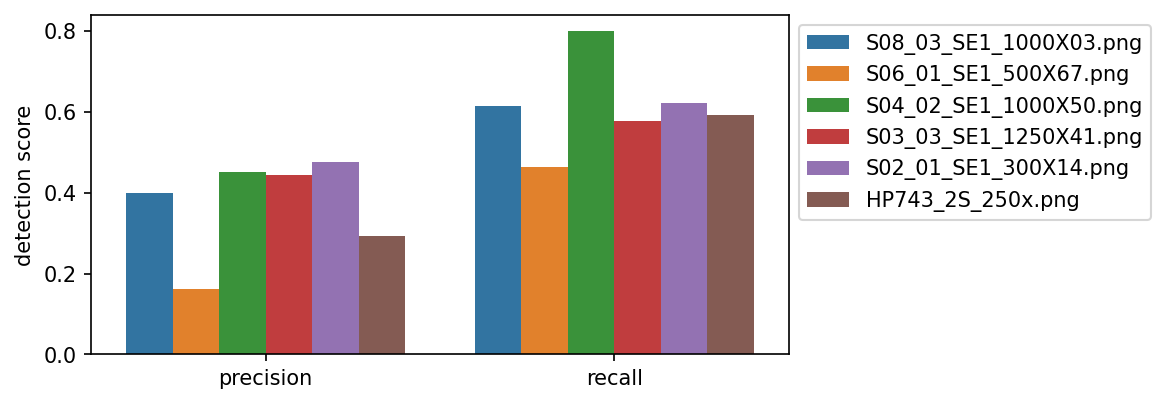

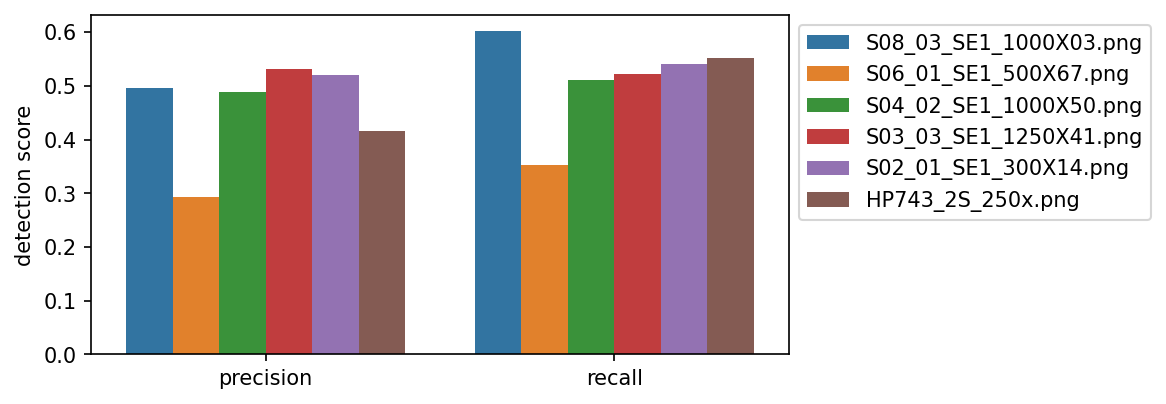

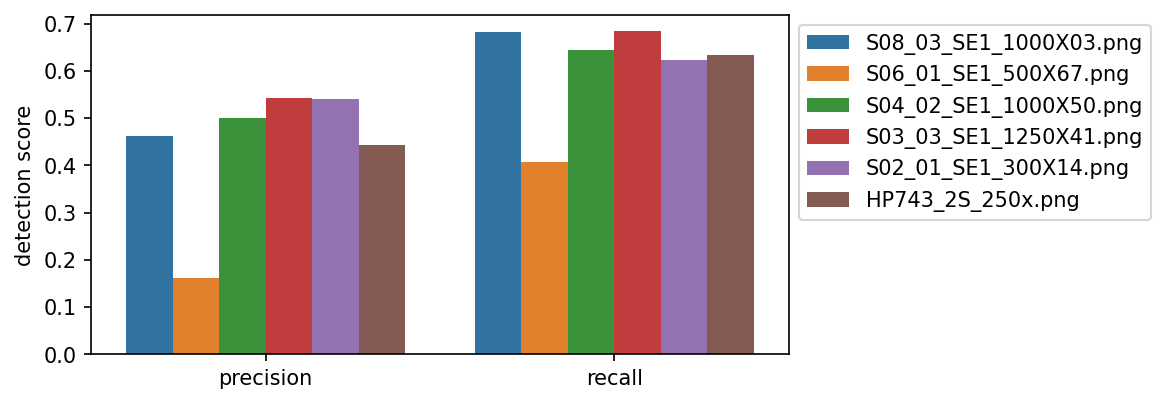

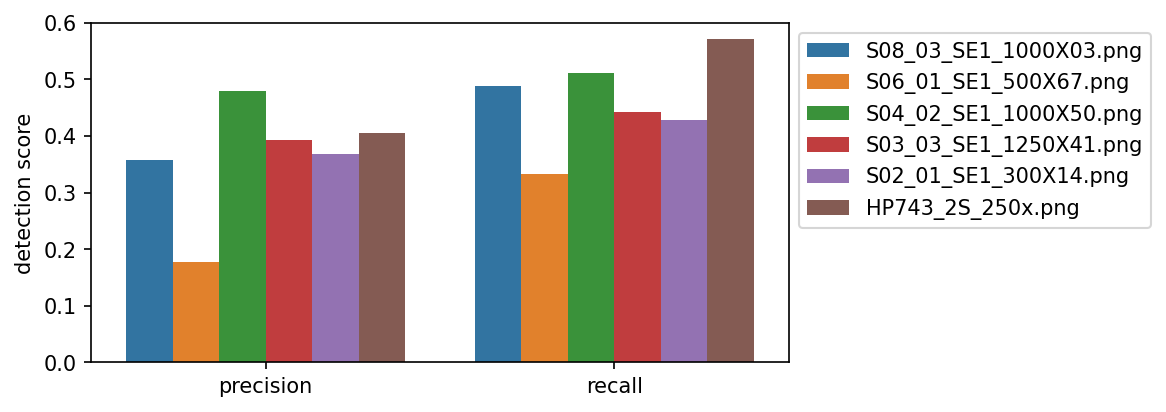

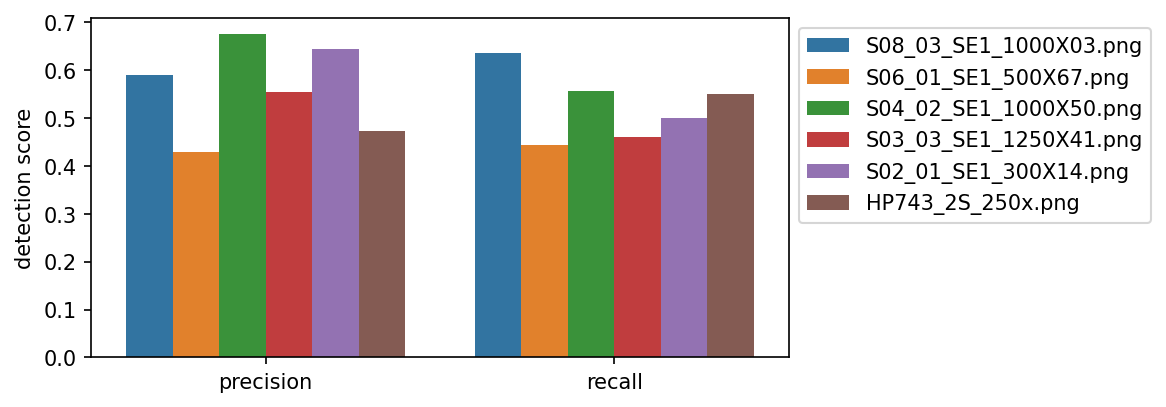

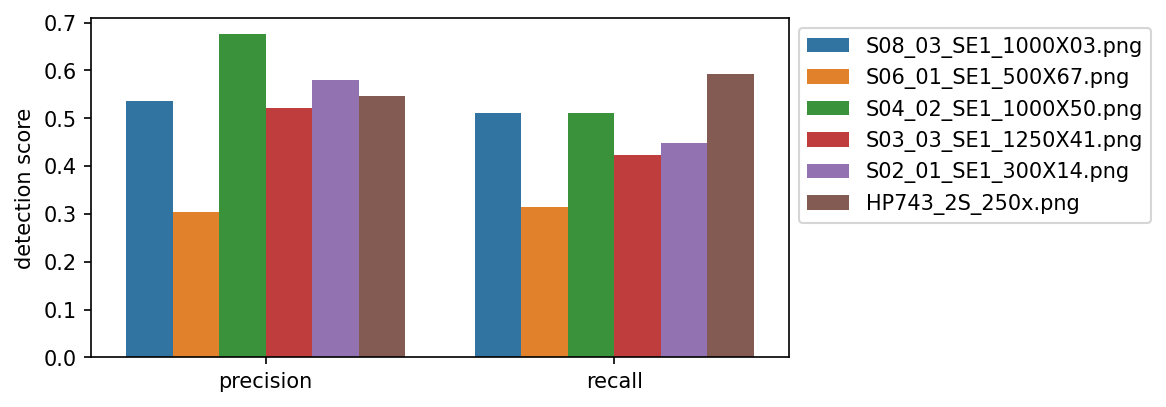

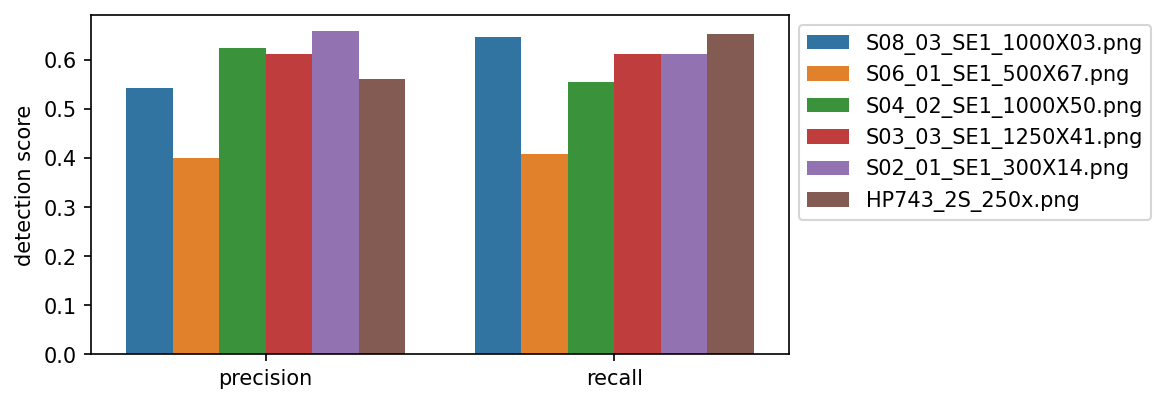

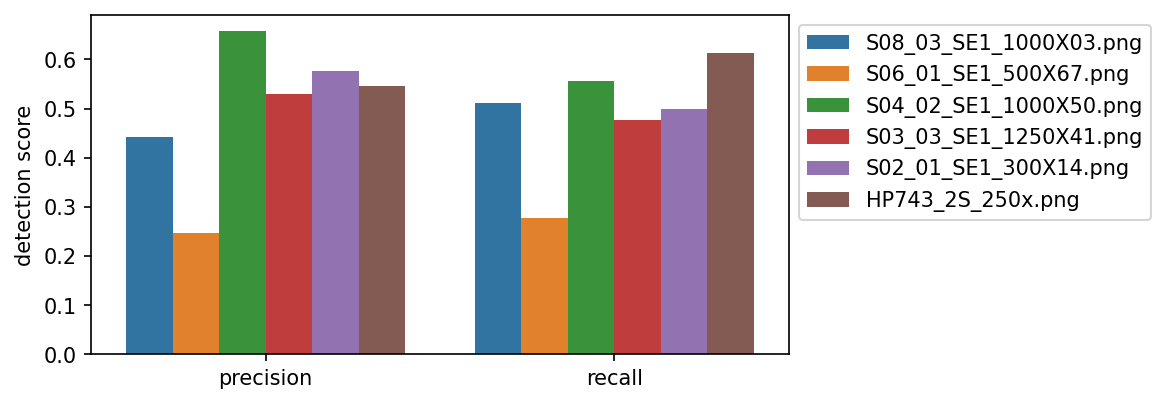

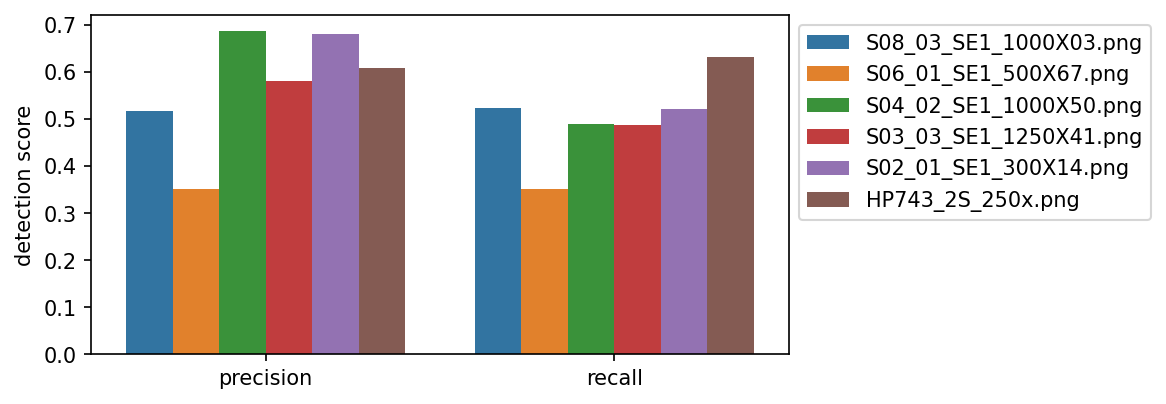

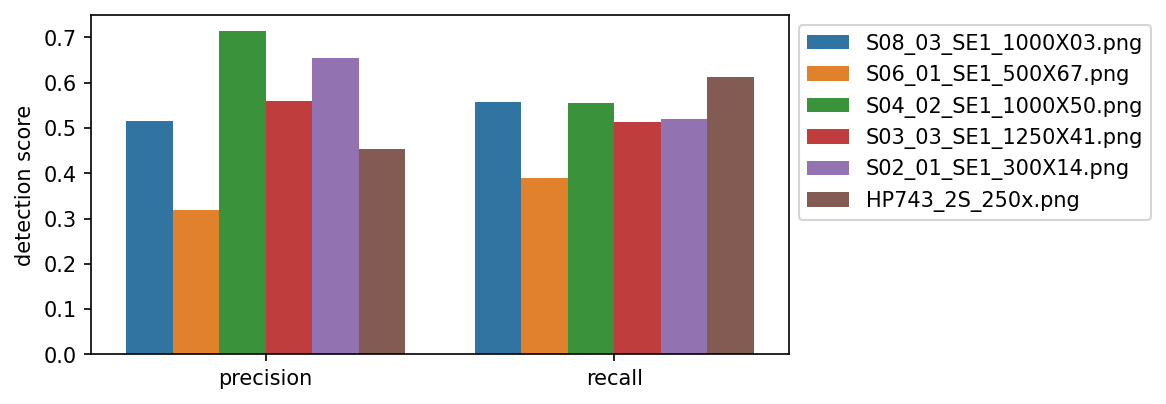

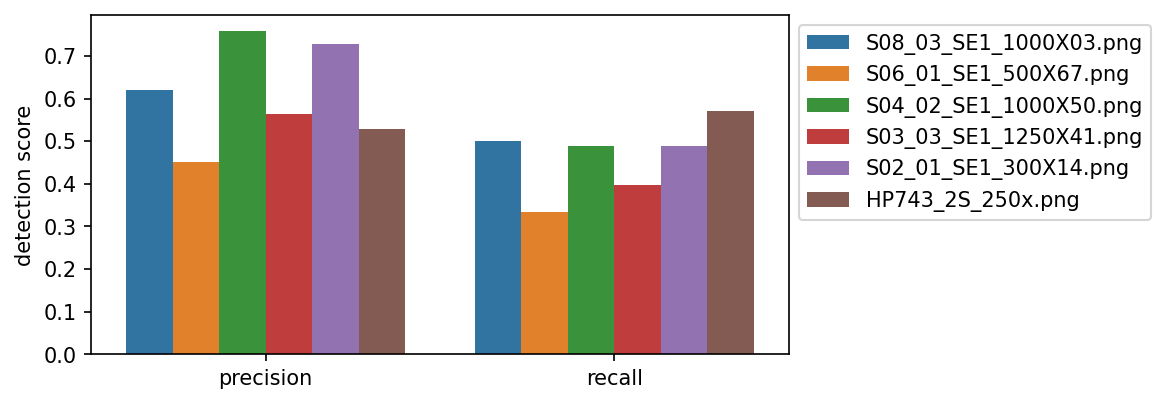

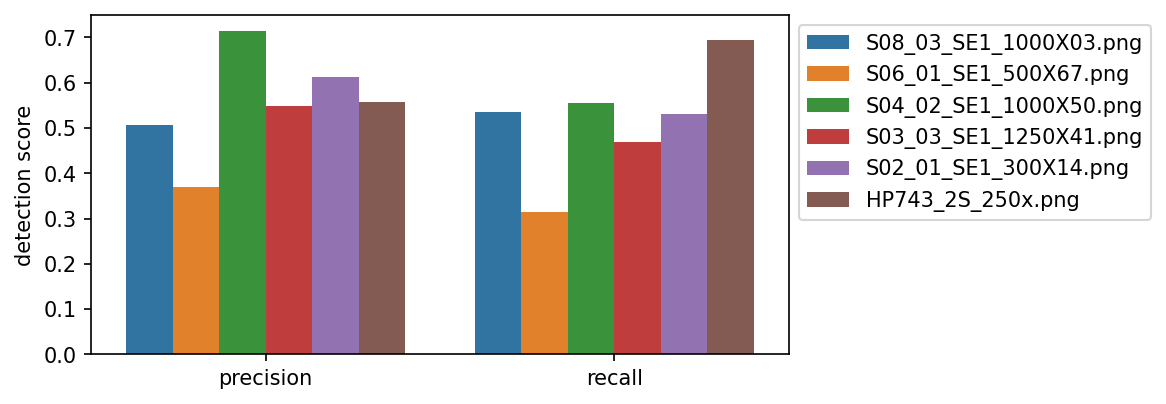

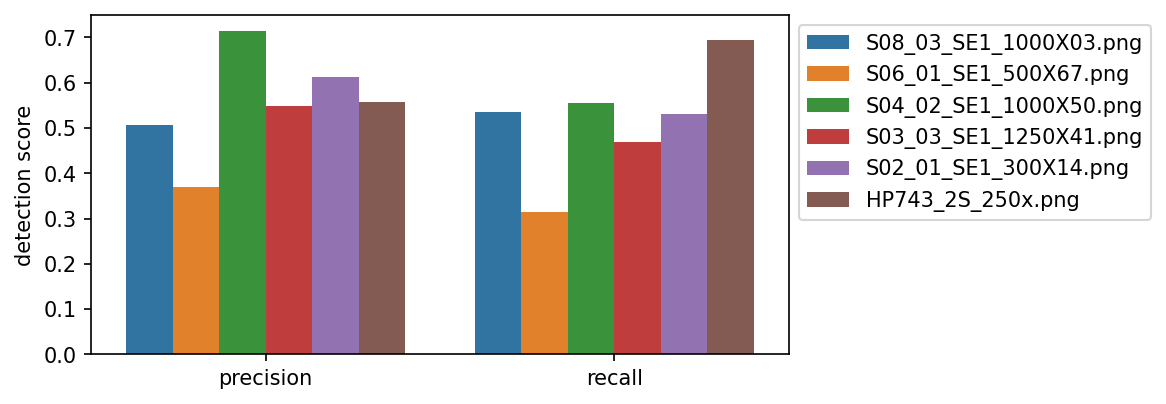

In [22]:
average_p = []
average_r = []
for i in range(0,13):
    #Loading Ground Truth Labels
    satellites_gt_path = Path('..', 'validating', 'satellite_auto_validation_v1.2.json')
    for path in [satellites_gt_path]:
        assert path.is_file(), f'File not found : {path}'
    satellites_gt_dd = data_utils.get_ddicts('via2', satellites_gt_path, dataset_class='train')
    #Loading Prediction Labels
    satellites_path = Path('iteration_training', f'satellite-stage-transformation-{i}.pickle')
    assert satellites_path.is_file()
    with open(satellites_path, 'rb') as f:
        satellites_pred = pickle.load(f)
    iset_satellites_gt = [InstanceSet().read_from_ddict(x, inplace=False) for x in satellites_gt_dd]
    iset_satellites_pred = [InstanceSet().read_from_model_out(x, inplace=False) for x in satellites_pred]
    #Creating Instance Set Objects
    iset_satellites_gt, iset_satellites_pred = analyze.align_instance_sets(iset_satellites_gt, iset_satellites_pred)
    #Re-ordering instance sets to be concurrent
    for gt, pred in zip(iset_satellites_gt, iset_satellites_pred):
        pred.HFW = gt.HFW
        pred.HFW_units = gt.HFW_units
        print(f'gt filename: {Path(gt.filepath).name}\t pred filename: {Path(pred.filepath).name}')
    #Creating Detection Scores
    dss_satellites = [analyze.det_seg_scores(gt, pred, size=gt.instances.image_size)
                     for gt, pred in zip(iset_satellites_gt, iset_satellites_pred)]
    labels = []
    counts = {'train': 0, 'validation': 0}
    for iset in iset_satellites_gt:
        counts[iset.dataset_class] += 1
        labels.append(iset.filepath.name)
    x=[*([1] * len(labels)), *([2] * len(labels))]
    # y values are the bar heights

    scores = [*[x['det_precision'] for x in dss_satellites],
         *[x['det_recall'] for x in dss_satellites]]
    labels = labels * 2
    print('x: ', x)
    print('y: ', [np.round(x, decimals=2) for x in scores])
    #print('labels: ', labels)
    fig, ax = plt.subplots(figsize=(6,3), dpi=150)
    sns.barplot(x=x, y=scores, hue=labels, ax=ax)
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel('detection score')
    ax.set_xticklabels(['precision','recall'])
    print("Average Precision Score: ", str(sum([*[x['det_precision'] for x in dss_satellites]])/len([*[x['det_precision'] for x in dss_satellites]])))
    print("Average Precision Score: ", str(sum([*[x['det_recall'] for x in dss_satellites]])/len([*[x['det_recall'] for x in dss_satellites]])))
    #Analyzing Prediction Scores on a pixel level
    temp_p = []
    temp_r = []
    total_area = 1024*768
    for instance in range(len(iset_satellites_pred)):
        fp_area = 0
        fn_area = 0
        tp_area = 0
        iset_satellites_pred[instance].compute_rprops(keys=['area'])
        for i in dss_satellites[instance]['det_fp']:
            try: 
                fp_area += int(iset_satellites_pred[instance].rprops['area'][i])
            except:
                pass

        for i in dss_satellites[instance]['det_fn']:
            try: 
                fn_area += int(iset_satellites_pred[instance].rprops['area'][i])
            except:
                pass

        #print(dss_satellites[0]['seg_tp'])
        for i in dss_satellites[instance]['det_tp']:
            try: 
                tp_area += int(iset_satellites_pred[instance].rprops['area'][i[1]])
            except:
                pass
        print("Precision:", str(tp_area/(tp_area+fp_area)))
        print('Recall:', str(tp_area/(tp_area+fn_area)))
        temp_p.append(tp_area/(tp_area+fp_area))
        temp_r.append(tp_area/(tp_area+fn_area))
        print('---')
    average_p.append(temp_p)
    average_r.append(temp_r)
    counter = 0   
    for iset in iset_satellites_gt:
        gt = iset_satellites_gt[counter]
        pred = iset_satellites_pred[counter]
        iset_det, colormap = analyze.det_perf_iset(gt, pred)
        img = skimage.color.gray2rgb(skimage.io.imread(iset.filepath))
        #display_iset(img, iset=iset_det)
        counter += 1
        


In [23]:
S08_1000 = []
S06_500 = []
S04_1000 = []
S03_1250 = []
S02_300 = []
HP_250 = []
for i in range(len(average_p)):
    S08_1000.append([i, average_p[i][0]])
    S06_500.append([i, average_p[i][1]])
    S04_1000.append([i, average_p[i][2]])
    S03_1250.append([i, average_p[i][3]])
    S02_300.append([i, average_p[i][4]])
    HP_250.append([i, average_p[i][5]])
print(S03_1250)

[[0, 0.48875663612078585], [1, 0.47691477356361317], [2, 0.40320636451301833], [3, 0.43329573420836753], [4, 0.5651372280461465], [5, 0.5051662294555384], [6, 0.624645656161414], [7, 0.5698975946653965], [8, 0.5641751386321626], [9, 0.6019231954632313], [10, 0.6507302989130435], [11, 0.6485376389774096], [12, 0.6485376389774096]]


# Segmenting Results of Satellite Detection
### S03_1250x

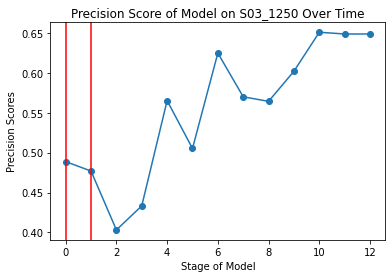

In [24]:
plt.title("Precision Score of Model on S03_1250 Over Time")
xyz = np.array(S03_1250)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(0, c='r')
plt.axvline(1, c='r')
print('')

### S06_500x


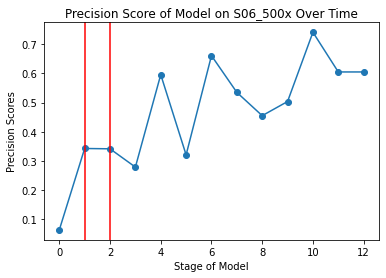

In [25]:
plt.title("Precision Score of Model on S06_500x Over Time")
xyz = np.array(S06_500)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(1, c='r')
plt.axvline(2, c='r')
print('')

### S02_300

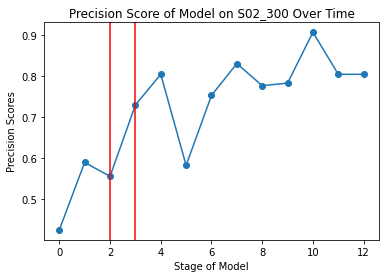

In [26]:
plt.title("Precision Score of Model on S02_300 Over Time")
xyz = np.array(S02_300)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(2, c='r')
plt.axvline(3, c='r')
print('')

### HP_250

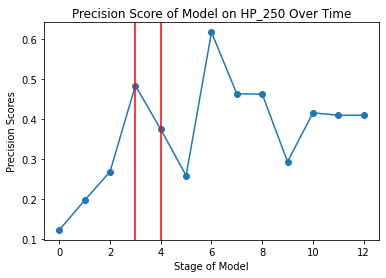

In [27]:
plt.title("Precision Score of Model on HP_250 Over Time")
xyz = np.array(HP_250)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(3, c='r')
plt.axvline(4, c='r')
print('')

### S08_1000x

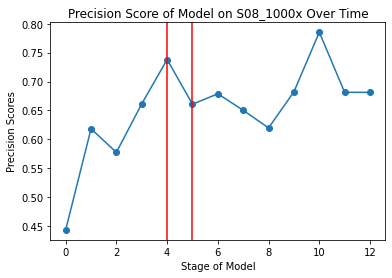

In [28]:
plt.title("Precision Score of Model on S08_1000x Over Time")
xyz = np.array(S08_1000)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(4, c='r')
plt.axvline(5, c='r')
print('')

### S04_1000

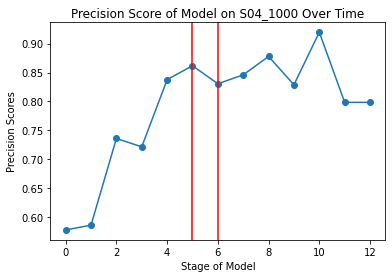

In [29]:
plt.title("Precision Score of Model on S04_1000 Over Time")
xyz = np.array(S04_1000)
plt.ylabel("Precision Scores")
plt.xlabel("Stage of Model")
plt.scatter(xyz[:,0], xyz[:,1])
plt.plot(xyz[:,0], xyz[:,1])
plt.axvline(5, c='r')
plt.axvline(6, c='r')
print('')